In [12]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from sklearn.decomposition import PCA
from pathlib import Path
import os
import sys
import hydra
import hydra.core.global_hydra
import pandas as pd
import torch
import torch.nn as nn
from omegaconf import DictConfig
from tqdm import tqdm
from IPython.display import HTML

# Define the project root directory name
PROJECT_ROOT_DIR = "latent-communication"

current_dir = os.getcwd()

# Find the project root by walking up the directory tree
while current_dir:
    if os.path.basename(current_dir) == PROJECT_ROOT_DIR:
        break  # Found the project root!
    current_dir = os.path.dirname(current_dir)
else:
    raise FileNotFoundError(f"Project root '{PROJECT_ROOT_DIR}' not found in the directory tree.")

os.chdir(current_dir)
# Add the project root and any necessary subdirectories to sys.path
sys.path.insert(0, current_dir) 
sys.path.insert(0, os.path.join(current_dir, "utils"))  # Add the utils directory if needed

from utils.dataloaders.get_dataloaders import define_dataloader
from utils.get_mapping import load_mapping
from utils.model import load_model
import matplotlib as mpl

DEVICE = (
    torch.device("cuda")
    if torch.cuda.is_available()
    else torch.device("mps") if torch.backends.mps.is_available() else "cpu"
)
hydra.core.global_hydra.GlobalHydra.instance().clear()

In [13]:
dict_losses = pd.DataFrame(columns=[])
pth_files = [file for file in os.listdir("models/checkpoints/PCKTAE/FMNIST/") if file.endswith(".pth")]

os.chdir("/Users/federicoferoggio/Documents/vs_code/latent-communication/")
for file in pth_files:
    file = file[:-4]
    name_dataset1, name_model1, size_of_the_latent1, seed1 = file.split("_")
    images, labels, n_classes = define_dataloader(name_dataset1, name_model1, seed=seed1, use_test_set=False)
    name_dataset2, name_model2, size_of_the_latent2, seed2 = file.split("_")

    filepath = f"models/checkpoints/PCKTAE/FMNIST/{name_dataset2}_{name_model2}_{size_of_the_latent2}_{seed2}.pth"
    model2 = load_model(
        model_name=name_model2,
        name_dataset=name_dataset2,
        latent_size=size_of_the_latent2,
        seed=seed2,
        model_path=filepath,
    ).to(DEVICE)
    model2.eval()
    reconstructed = model2(images.to(DEVICE).float())
    loss = nn.MSELoss()
    loss_value = loss(reconstructed, images.to(DEVICE).float())
    print(file, f"{loss_value.item():.4f}")
    

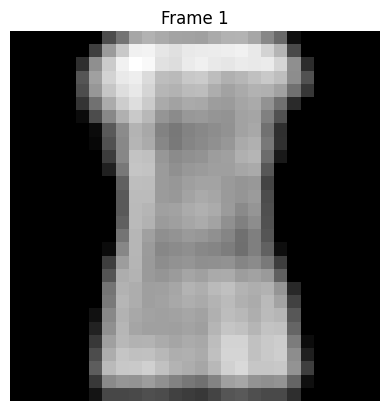

In [ ]:
import os
import torch
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import HTML, display
from sklearn.decomposition import PCA

# Placeholder variables
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
num_frames = 100  # Set the number of frames for the animation

file  = "FMNIST_PCKTAE_100_1.pth"
file = file[:-4]
name_dataset1, name_model1, size_of_the_latent1, seed1 = file.split("_")
images, labels, n_classes = define_dataloader(name_dataset1, name_model1, seed=seed1, use_test_set=False)
name_dataset2, name_model2, size_of_the_latent2, seed2 = file.split("_")

filepath = f"models/checkpoints/PCKTAE/FMNIST/{name_dataset2}_{name_model2}_{size_of_the_latent2}_{seed2}.pth"
model2 = load_model(
    model_name=name_model2,
    name_dataset=name_dataset2,
    latent_size=size_of_the_latent2,
    seed=seed2,
    model_path=filepath,
).to(DEVICE)
model2.eval()

# Get latent representations
latent1 = model2.get_latent_space(images[5].unsqueeze(0).to(DEVICE)).detach().cpu().numpy()   
latent2 = model2.get_latent_space(images[3].unsqueeze(0).to(DEVICE)).detach().cpu().numpy() 

# Generate intermediate latent representations
transformed_data_frames = [latent1 * (frame/num_frames) + (1 - frame/num_frames) * latent2 for frame in range(num_frames)]
transformed_latent_space = np.asarray(transformed_data_frames)

# Function to decode latent vectors to images
def decode_latent_vectors(model, latent_vectors):
    decoded_images = []
    for latent in latent_vectors:
        latent_tensor = torch.tensor(latent).to(DEVICE).unsqueeze(0)
        decoded_image = model.decode(latent_tensor).cpu()
        decoded_images.append(decoded_image)
    return decoded_images

# Decode the intermediate latent representations to images
decoded_images = decode_latent_vectors(model2, transformed_latent_space)

# Function to reverse the ToTensor transformation
def tensor_to_image(tensor):
    tensor = tensor.squeeze(0)  # Remove batch dimension
    tensor = tensor.mul(255).byte()  # Scale the pixel values back to [0, 255]
    array = tensor.numpy()  # Convert to numpy array
    array = array.reshape(28, 28)  # Reshape to 28x28
    return array

# Initialize plot
fig, ax = plt.subplots()

# Function to update the plot for each frame
def update(frame):
    ax.clear()
    img = tensor_to_image(decoded_images[frame])
    ax.imshow(img, cmap='gray')
    ax.set_title(f"Frame {frame + 1}")
    ax.axis('off')
    return ax

# Create animation
animation = FuncAnimation(fig, update, frames=num_frames, blit=False)
html = animation.to_jshtml()

# Display the animation
display(HTML(html))


In [3]:
import os
os.chdir("/Users/federicoferoggio/Documents/vs_code/latent-communication/")

In [4]:
import os
import itertools
from collections import defaultdict

# Define directories and parameters
folder1 = "models/checkpoints/PCKTAE/FMNIST"
folder2 = "models/checkpoints/PCKTAE/FMNIST"
number_samples = [10, 25, 50, 75, 100, 200, 300]
mapping_list = ["Linear", "Affine"]
lamda_list = [0, 0.01]
filter1 = '_'
filter2 = '_'

# Collect all the required combinations
files1 = [f for f in os.listdir(folder1) if f.endswith(".pth") and filter1 in f]
files2 = [f for f in os.listdir(folder2) if f.endswith(".pth") and filter2 in f]
list_of_files = [(f1, f2) for f1, f2 in itertools.product(files1, files2) if f1 != f2]
combinations_parameters = list(itertools.product(number_samples, mapping_list, lamda_list))
combinations = list(itertools.product(list_of_files, combinations_parameters))
flattened_combinations = [(file1, file2, param1, param2, param3) for ((file1, file2), (param1, param2, param3)) in combinations]

# Initialize a dictionary to store progress
progress_dict = defaultdict(lambda: {"completed": 0, "total": 0})

# Check the directory for existing transformations
for file1, file2, num_samples, mapping, lamda in flattened_combinations:
    name_dataset1, name_model1, size_of_the_latent1, seed1 = file1.strip(".pth").split("_")
    name_dataset2, name_model2, size_of_the_latent2, seed2 = file2.strip(".pth").split("_")
    folder_path = f'results/transformations/mapping_files/{name_model2}'
    
    progress_dict[file1]["total"] += 1
    
    # Expected file name patterns
    file_patterns = [
        f"{file1.strip('.pth')}>{file2.strip('.pth')}>{mapping}_{num_samples}_{lamda}_{'equally'}.npz",
        f"{file1.strip('.pth')}>{file2.strip('.pth')}>{mapping}_{num_samples}_{lamda}_{'outliers'}.npz",
        f"{file1.strip('.pth')}>{file2.strip('.pth')}>{mapping}_{num_samples}_{lamda}_{'worst_classes'}.npz",
        f"{file1.strip('.pth')}>{file2.strip('.pth')}>{mapping}_{num_samples}_{lamda}_{'convex_hull'}.npz"
    ]

    # Check if any of these files exist
    found = any(os.path.isfile(os.path.join(folder_path, pattern)) for pattern in file_patterns)

    if found:
        progress_dict[file1]["completed"] += 1

# Create a list of results with progress information
results = []
for model, progress in progress_dict.items():
    total = progress["total"]
    completed = progress["completed"]
    percentage = (completed / total) * 100 if total > 0 else 0
    results.append((model, percentage, total - completed))

# Sort the results by completion percentage
sorted_results = sorted(results, key=lambda x: x[1], reverse=True)

# Print the sorted results
for model, percentage, remaining in sorted_results:
    print(f"{model}: {percentage:.2f}% complete ({remaining} mappings left)")


FMNIST_PCKTAE_100_3.pth: 50.00% complete (154 mappings left)
FMNIST_PCKTAE_100_2.pth: 50.00% complete (154 mappings left)
FMNIST_PCKTAE_100_1.pth: 50.00% complete (154 mappings left)
FMNIST_PCKTAE_10_1.pth: 50.00% complete (154 mappings left)
FMNIST_PCKTAE_10_2.pth: 50.00% complete (154 mappings left)
FMNIST_PCKTAE_10_3.pth: 50.00% complete (154 mappings left)
FMNIST_PCKTAE_30_1.pth: 18.51% complete (251 mappings left)
FMNIST_PCKTAE_50_1.pth: 7.47% complete (285 mappings left)
FMNIST_PCKTAE_50_3.pth: 7.47% complete (285 mappings left)
FMNIST_PCKTAE_50_2.pth: 7.47% complete (285 mappings left)
FMNIST_PCKTAE_30_2.pth: 7.47% complete (285 mappings left)
FMNIST_PCKTAE_30_3.pth: 7.47% complete (285 mappings left)
